In [1]:
import pprint as pp
import os
import sys
import pandas as pd
import numpy as np
from importlib import reload 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Update path 
"""

sys.path.append("../")

In [3]:
"""
Local imports
"""

import imagePipeline.data_io.loaders as _read
import imagePipeline.data_io.writers as _write
import imagePipeline.preprocess.transform as _prep

In [4]:
%time
"""
Load the parameter file into memory
"""
params = _read.load_params(params_path="../inputs/proliferation_params.json")

"""
load the CZIs from the data directory
"""
reload(_read)

loader = _read.cziLoader(params)  
czi, metadata = loader.get_item(index=0)

print("done.")

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs
done.


In [5]:
# pp.pprint(metadata)

In [25]:
%time

reload(_prep)

"""
initialize the transformer
"""

params = _read.load_params(params_path="../inputs/proliferation_params.json")
transformer = _prep.ParallelTransformer(params, metadata)

"""
create a subset of test data
"""

N_TIME = 1
TEST_IMG = czi.data[:, 0:N_TIME, :, :, :, :]

print(TEST_IMG.shape)

"""
tranform
"""

processed = transformer.process(czi_data=TEST_IMG)
print(f"chain: {transformer.chain}")
print(processed.shape)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
(1, 1, 4, 30, 472, 652)
(4, 1, 30, 118, 163)
chain: ['resize', 'log', 'local_eq', 'ball', 'eq_hist', 'dilate']


AttributeError: 'NoneType' object has no attribute 'shape'

(-0.5, 651.5, 471.5, -0.5)

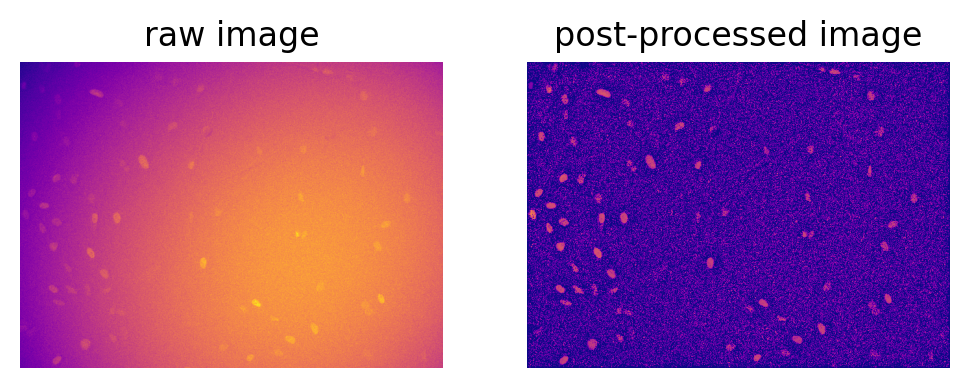

In [7]:
"""
plot results
"""

matplotlib.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(nrows=1, ncols=2)

t = 1
tile = 6 
c = 1

raw_img = TEST_IMG[0, t, c, tile, :, :]
processed_img = processed[0, t, c, tile, :, :]

CMAP = 'plasma'

ax[0].imshow(raw_img, cmap=CMAP)
ax[0].set_title("raw image")
ax[0].axis(False)

ax[1].imshow(processed_img, cmap=CMAP)
ax[1].set_title("post-processed image")
ax[1].axis(False)

Text(0.5, 1.0, 'processed image')

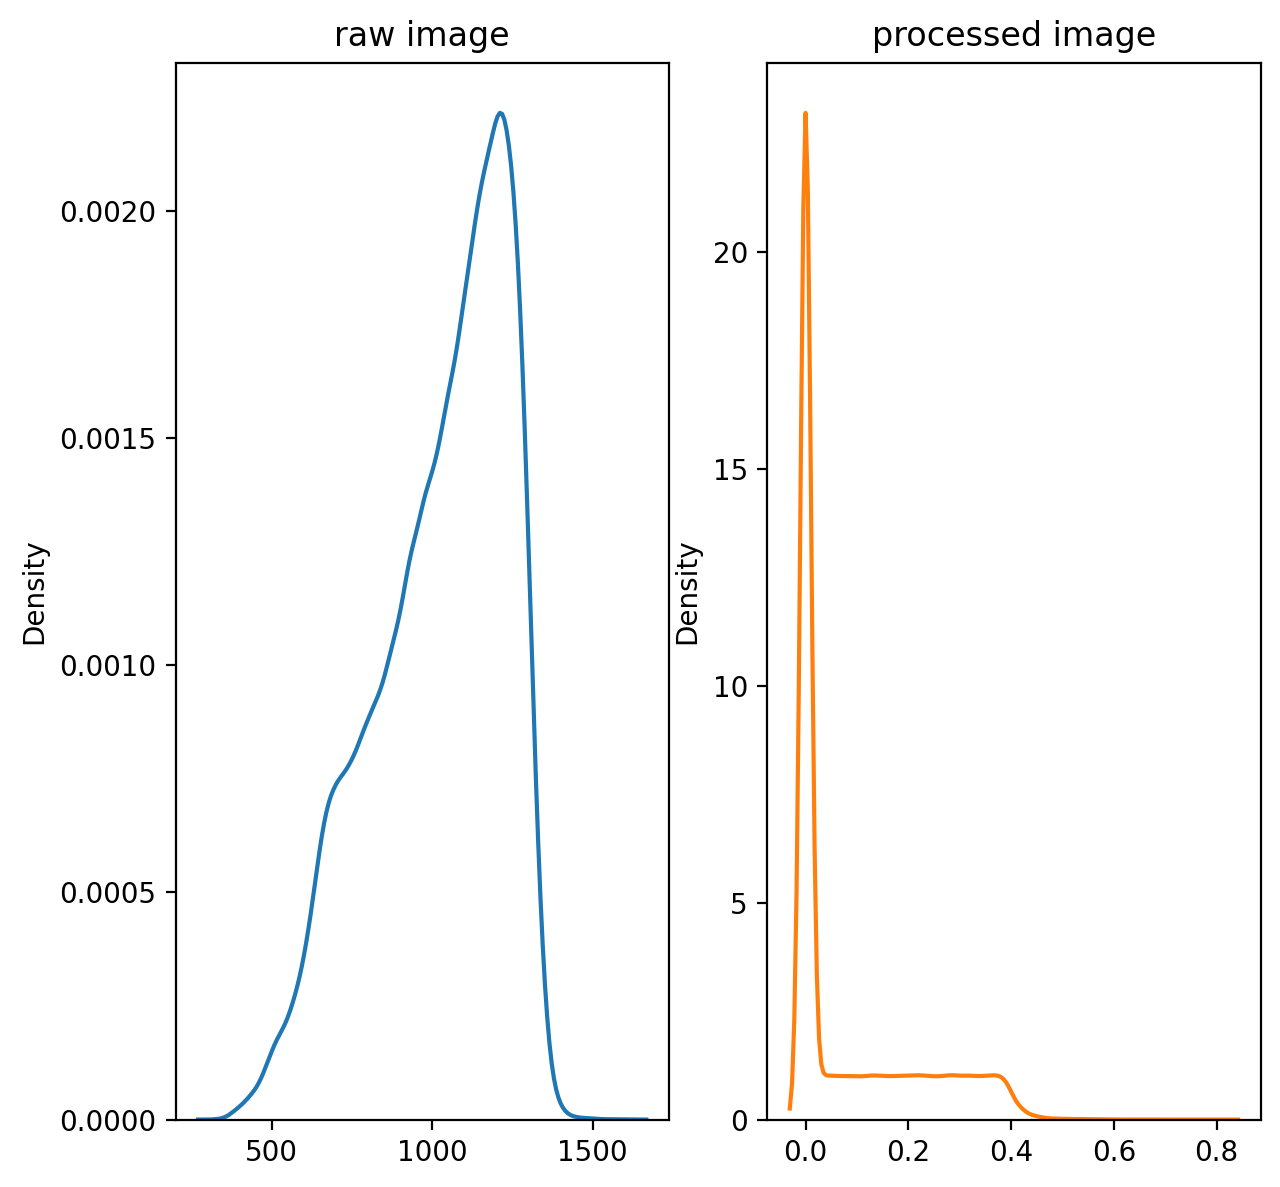

In [8]:
"""
plot pizel values
"""
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 7)
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.kdeplot(raw_img.flatten(), ax=ax[0])
ax[0].set_title('raw image')

sns.kdeplot(processed_img.flatten(), ax=ax[1], color='C1')
ax[1].set_title('processed image')

In [18]:
%time
reload(_prep)

params = _read.load_params(params_path="../inputs/proliferation_params.json")
transformer = _prep.ParallelTransformer(params, metadata)

stitched = transformer.stitch(processed)
print(stitched.shape)
print("done.")

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10 µs
(1, 100, 4, 1, 590, 978)
done.


Text(0.5, 1.0, 'Stitched Image')

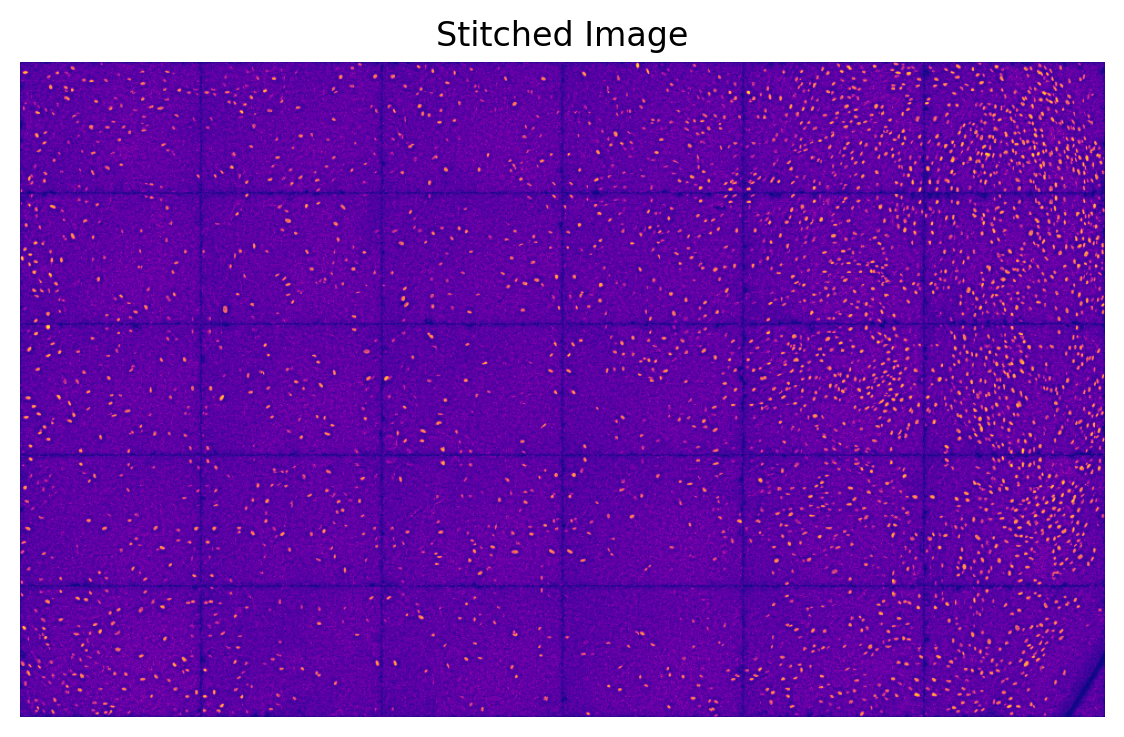

In [10]:
t = 1
c = 1

stitched_img = stitched[0, t, c, 0, :, :]

plt.imshow(stitched_img, cmap=CMAP)
plt.axis(False)
plt.title("Stitched Image")

Text(0.5, 1.0, 'Stitched Image Post-Processing')

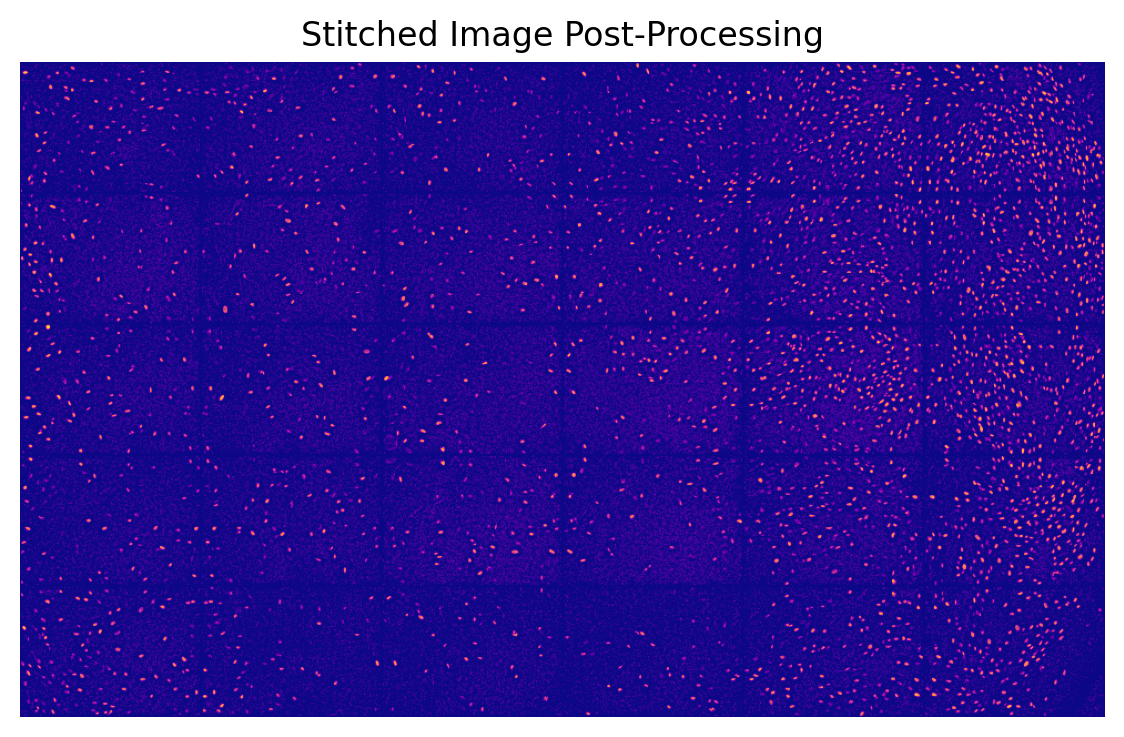

In [11]:
"""
process the whole stitched image 
"""
stitched_img_p = transformer.dilate(stitched_img)
plt.imshow(stitched_img_p, cmap=CMAP)
plt.axis(False)
plt.title("Stitched Image Post-Processing")

In [17]:
t = 1
c = 3

stitched_img = stitched[0, t, c, 0, :, :]
stitched_img.mean()

8191.857398821643

In [12]:
%time
reload(_write)

writer = _write.OutputWriter(params, metadata)

# save parameters 
writer.save_params()
print()

# save metadata
writer.save_metadata()
print()

# save ome_tiff
writer.write_ome(stitched)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 10.3 µs
Saved: `/home/cstansbu/GIT_REPOSITORIES/cell_tracking/outputs/PARAMETERS_2015-05-13-20-Scene12-D3.json`

Saved: `/home/cstansbu/GIT_REPOSITORIES/cell_tracking/outputs/METADATA_2015-05-13-20-Scene12-D3.json`

saved: /home/cstansbu/GIT_REPOSITORIES/cell_tracking/outputs/OME_2015-05-13-20-Scene12-D3.tiff


In [13]:
stitched.shape

(1, 100, 4, 1, 590, 978)